# Notch stress singularity and mesh convergence

*Author: Arthur Cornet*

## Problem description

We apply a traction on a 2D plate, and want to evaluate the maximal stress, which is located at the tip of a v-shaped notch. We will generate the mesh with Gmsh, then run a finite element simulation using Akantu. In a second time, we will study the influence of the elements size on the value of the notch stress.

![](Figures/notch_problem.png)

## Imports

In [1]:
import akantu as aka
import numpy as np
import matplotlib.pyplot as plt # plot figures
import matplotlib.tri as tri # plot meshes
plt.rcParams['figure.figsize'] = [10, 10] # large default image size

## Material file

We consider an elastic constitutive law, with a stiffness matching a typical steel.

In [2]:
material_file = """
material elastic [
    name = steel
    rho = 7800     # density
    E   = 2.1e11   # young's modulus
    nu  = 0.3      # poisson's ratio
]"""
# writing the material file
open('material.dat', 'w').write(material_file)
#reading the material file
material_file = 'material.dat'
aka.parseInput(material_file)

## Mesh

*Gmsh* mesher is used to generate a triangular mesh loadable with Akantu. 

In [3]:
# Geometric parameters

w = 6.      # width (x-axis)
l = 4.      # length (y-axis)
h1 = 0.1    # characteristic mesh size around the notch
h2 = 0.5    # characteristic mesh size in corners
R = 2.      # length of crack
s = 0.5     # crack opening size

### Geometry description

In [4]:
# Points {x, y, z, h}
mesh_file = f"""
Point(1) = {{0, 0, 0, {h2} }};
Point(2) = {{ {w}, 0, 0, {h2} }};
Point(3) = {{ {w}, {l}, 0, {h2} }};
Point(4) = {{ 0,   {l}, 0, {h2} }};
Point(5) = {{ 0,   {(l+s)/2.}, 0, {h1} }};
Point(6) = {{ {R},   {l/2.}, 0, {h1} }};
Point(7) = {{ 0,   {(l-s)/2.}, 0, {h1} }};
"""

# Lines and plane surface
mesh_file += """
Line(1) = {1, 2};
Line(2) = {2, 3};
Line(3) = {3, 4};
Line(4) = {4, 5};
Line(5) = {5, 6};
Line(6) = {6, 7};
Line(7) = {7, 1};
Line Loop(8) = {1, 2, 3, 4, 5, 6, 7};
Plane Surface(9) = {8};
"""

# Physical subparts
mesh_file += """
Physical Surface(10) = {9};
Physical Line("XBlocked") = {2};
Physical Line("YBlocked") = {1};
Physical Line("Traction") = {3};
"""

### Write the file and generate the mesh

In [5]:
open('plate.geo', 'w').write(mesh_file)

import subprocess
ret = subprocess.run("gmsh -2 -order 1 -o plate.msh plate.geo", shell=True)
if ret.returncode:
    print("Beware, gmsh could not run: mesh is not regenerated")
else:
    print("Mesh generated")

Info    : Running '/usr/local/bin/gmsh -2 -order 1 -o plate.msh plate.geo' [Gmsh 4.9.4, 1 node, max. 1 thread]
Info    : Started on Fri Apr  1 00:25:02 2022
Info    : Reading 'plate.geo'...
Info    : Done reading 'plate.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.0124441s, CPU 0.010977s)
Info    : Meshing 2D...
Info    : Meshing surface 9 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.016946s, CPU 0.015973s)
Info    : 398 nodes 801 elements
Info    : Writing 'plate.msh'...
Info    : Done writing 'plate.msh'
Info    : Stopped on Fri Apr  1 00:25:02 2022 (From start: Wall 0.106929s, CPU 0.449226s)
Mesh generated


## Reading the mesh with Akantu

In [6]:
# reading the mesh
spatial_dimension = 2    
mesh_file = 'plate.msh'
mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

### Plot the mesh

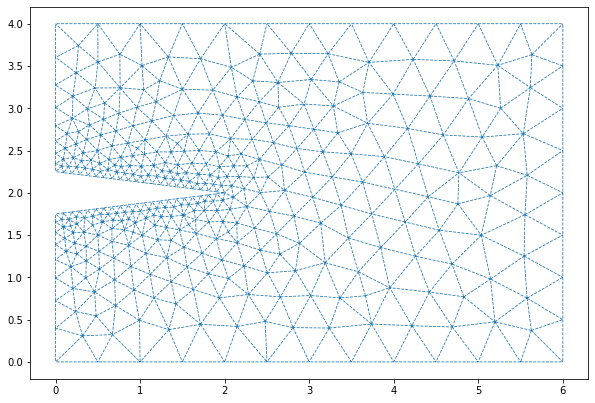

In [7]:
# extract the mesh
conn = mesh.getConnectivity(aka._triangle_3)
nodes = mesh.getNodes()
triangles = tri.Triangulation(nodes[:, 0], nodes[:, 1], conn)

# plot the result
plt.axes().set_aspect('equal')
# plots the pristine state
t = plt.triplot(triangles, '--', lw=.8)

## Solving

In [8]:
# creating the solid mechanics model
model = aka.SolidMechanicsModel(mesh)

# initialize a static solver
model.initFull(_analysis_method=aka._static)

# set the displacement/Dirichlet boundary conditions
model.applyBC(aka.FixedValue(0.0, aka._x), "XBlocked")
model.applyBC(aka.FixedValue(0.0, aka._y), "YBlocked")

# set the force/Neumann boundary conditions
model.getExternalForce()[:] = 0
trac = [0, 10] # Newtons/m^2
model.applyBC(aka.FromTraction(trac), "Traction")

# configure the linear algebra solver
solver = model.getNonLinearSolver()
solver.set("max_iterations", 2)
solver.set("threshold", 1e-10)
solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

# compute the solution
model.solveStep()

## Ploting the results

### Extracting the displacement field

In [9]:
# extract the displacements
u = model.getDisplacement()

### Plotting deformed mesh

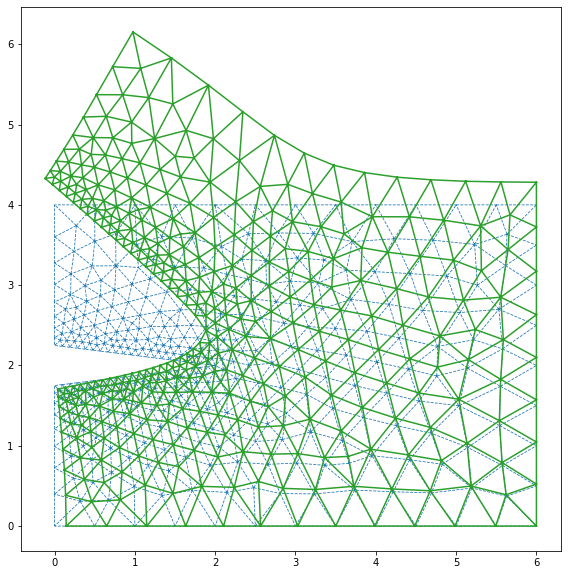

In [10]:
# plot the result
plt.axes().set_aspect('equal')
# plots the pristine state
t = plt.triplot(triangles, '--', lw=.8)
# plots an exagerating view of the strained mesh
t = plt.triplot(nodes[:, 0]+u[:,0]*2e9, nodes[:, 1]+u[:,1]*2e9, triangles=conn)

### Plotting the stress field

Maximum stress (norm) = 130.0 Pa


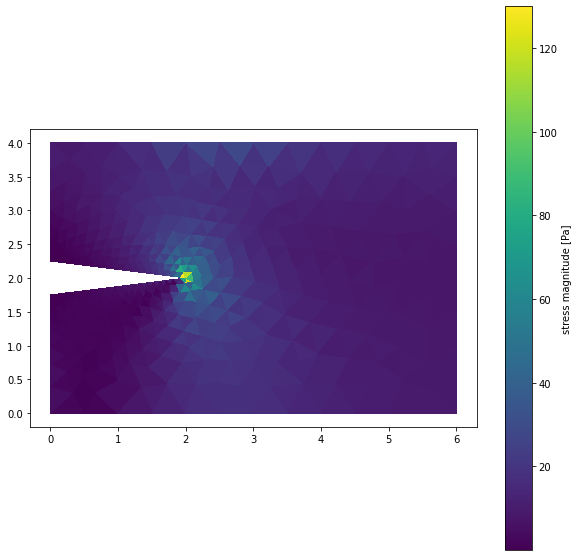

In [11]:
# plot stress field
plt.axes().set_aspect('equal')
stress_field = model.getMaterial(0).getStress(aka._triangle_3)
stress_disp = plt.tripcolor(triangles, np.linalg.norm(stress_field, axis=1))
cbar = plt.colorbar(stress_disp)
cbar.set_label('stress magnitude [Pa]')
print('Maximum stress (norm) = {:.1f} Pa'.format(np.max(np.linalg.norm(stress_field, axis=1))))

## Influence of mesh size

We want to see how the size of the mesh around the notch affects the maximum stress value at the notch tip.

In [12]:
import subprocess

def get_notch_stress(mesh_size):
    """
    Returns stress concentration at notch tip, for a given mesh size around it
    """
    
    # Geometric parameters
    w = 6.           # width (x-axis)
    l = 4.           # length (y-axis)
    h1 = mesh_size   # characteristic mesh size around the notch
    h2 = 0.5         # characteristic mesh size in corners
    R = 2.           # length of crack
    s = 0.5          # crack opening size
    
    # Writing mesh file
    mesh_file = f"""
    Point(1) = {{0, 0, 0, {h2} }};
    Point(2) = {{ {w}, 0, 0, {h2} }};
    Point(3) = {{ {w}, {l}, 0, {h2} }};
    Point(4) = {{ 0,   {l}, 0, {h2} }};
    Point(5) = {{ 0,   {(l+s)/2.}, 0, {h1} }};
    Point(6) = {{ {R},   {l/2.}, 0, {h1} }};
    Point(7) = {{ 0,   {(l-s)/2.}, 0, {h1} }};
    """
    mesh_file += """
    Line(1) = {1, 2};
    Line(2) = {2, 3};
    Line(3) = {3, 4};
    Line(4) = {4, 5};
    Line(5) = {5, 6};
    Line(6) = {6, 7};
    Line(7) = {7, 1};
    Line Loop(8) = {1, 2, 3, 4, 5, 6, 7};
    Plane Surface(9) = {8};
    """
    mesh_file += """
    Physical Surface(10) = {9};
    Physical Line("XBlocked") = {2};
    Physical Line("YBlocked") = {1};
    Physical Line("Traction") = {3};
    """
    
    # Generating mesh using gmesh
    open('plate.geo', 'w').write(mesh_file)
    ret = subprocess.run("gmsh -2 -order 1 -o plate.msh plate.geo", shell=True, stdout=subprocess.DEVNULL)
        
    # Reading the mesh with Akantu
    spatial_dimension = 2    
    mesh_file = 'plate.msh'
    mesh = aka.Mesh(spatial_dimension)
    mesh.read(mesh_file)
    
    # Configuring solver
    model = aka.SolidMechanicsModel(mesh)
    model.initFull(_analysis_method=aka._static)
    
    # Boundary conditions
    model.applyBC(aka.FixedValue(0.0, aka._x), "XBlocked")
    model.applyBC(aka.FixedValue(0.0, aka._y), "YBlocked")
    model.getExternalForce()[:] = 0
    trac = [0, 10] # Newtons/m^2
    model.applyBC(aka.FromTraction(trac), "Traction")
    
    # Solve problem
    solver = model.getNonLinearSolver()
    solver.set("max_iterations", 2)
    solver.set("threshold", 1e-10)
    solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)
    model.solveStep()
    
    # Get maximum stress norm
    stress_field = model.getMaterial(0).getStress(aka._triangle_3)
    notch_stress = np.max(np.linalg.norm(stress_field, axis=1))
    
    return notch_stress

Calculation done for mesh size = 0.5
Calculation done for mesh size = 0.25
Calculation done for mesh size = 0.125
Calculation done for mesh size = 0.0625
Calculation done for mesh size = 0.03125
Calculation done for mesh size = 0.015625
Calculation done for mesh size = 0.0078125
Calculation done for mesh size = 0.00390625
Calculation done for mesh size = 0.001953125


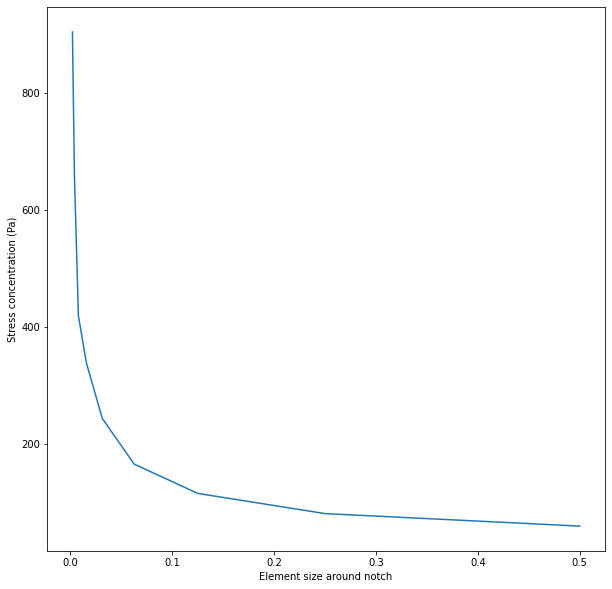

In [13]:
h = 0.5**np.arange(1,10) # mesh sizes

notch_stress_list = []
for mesh_size in h:
    notch_stress_list.append(get_notch_stress(mesh_size))
    print('Calculation done for mesh size = {h}'.format(h = mesh_size))
    
plt.plot(h,notch_stress_list)
plt.xlabel('Element size around notch')
plt.ylabel('Stress concentration (Pa)')
plt.show()

We observe that the norm of the notch stress seems to diverge as the elements get smaller. Indeed, linear elastic theory predicts that the stress distribution $\sigma _{ij}$ near the crack tip, in polar coordinates $(r, \theta)$ with origin at the crack tip, has the form:
$$
\sigma _{ij}(r, \theta) \sim \dfrac{K}{\sqrt{2 \pi r}}f_{ij}(\theta)
$$
so the norm of the stress should be infinite at the notch tip (where $r \rightarrow 0$). We call $K$ the *stress intensity factor*, which depends on the crack opening mode: this concept is used a lot in fracture theory.

Since in FEM, the stress on each element is computed from nodal values, we get a smaller notch stress value with larger elements.

## Conclusion

In FEM, **mesh convergence** must always be checked, which means that we have to make sure that the result does not vary much with the mesh size. If this is not done properly, some stress concentrations might be underestimated, which can have distastrous consequences from an engineering perspective. 

If the stress continues to increase locally even after some mesh refinement, it might be a case of **stress singularity** (like the one we have seen in this notebook), which requires specific tools, both analytical and numerical.